# Wilson-Cowan Model: Limit Cycle Oscillations

This notebook demonstrates **limit cycle** behavior in the Wilson-Cowan model.

## What are Limit Cycles?

A **limit cycle** is a closed trajectory in phase space that represents stable, self-sustained oscillations. Unlike damped oscillations that decay to a fixed point, limit cycles persist indefinitely without external periodic forcing.

## Neuroscience Relevance

Limit cycles in neural models can represent:
- **Cortical rhythms**: Alpha (8-12 Hz), beta (15-30 Hz), gamma (30-80 Hz) oscillations
- **Central pattern generators**: Rhythmic motor patterns (breathing, walking)
- **Oscillatory working memory**: Persistent activity patterns

## Key Mechanism for Limit Cycles

The Wilson-Cowan model exhibits limit cycles through **gain asymmetry**:

1. **Low excitatory gain (a_E)**: Makes E respond slowly and smoothly to inputs
2. **High inhibitory gain (a_I)**: Makes I respond sharply and sensitively to E
3. **High initial conditions**: Places system in oscillatory regime (not fixed point basin)
4. **No external drive**: Allows free oscillation without being clamped to fixed point

### The Oscillation Cycle:
1. E rises slowly (low gain) → drives I
2. I responds sharply (high gain) → strongly suppresses E
3. E drops → I decays
4. Cycle repeats

This gain asymmetry creates the phase lag needed for sustained oscillations, even with equal time constants (τ_E = τ_I).

In [1]:
# Imports and environment setup
import sys

sys.path.append(r'D:\codes\projects\brainmass')
sys.path.append(r'D:\codes\projects\brainstate')

import brainmass
import brainstate
import braintools
import brainunit as u
import matplotlib.pyplot as plt
import numpy as np

# Set integration time step
brainstate.environ.set(dt=0.1 * u.ms)

In [2]:
def simulate(
    tau_E=12.0 * u.ms,
    tau_I=10.0 * u.ms,
    a_E=1.3,
    theta_E=2.6,
    a_I=1.0,
    theta_I=4.0,
    P=1.5,
    Q=0.0,
    rE0=1.0,
    rI0=1.0,
    duration=5e2 * u.ms,
    **kwargs
):
    # Configure Wilson-Cowan model for limit cycle behavior
    model = brainmass.WilsonCowanNoSaturationStep(
        1,  # Single node
        tau_E=tau_E,  # Excitation time constant
        tau_I=tau_I,  # Inhibition time constant (equal timescales)

        # CRITICAL: Gain asymmetry creates oscillations
        a_E=a_E,  # Low gain for E (sluggish, smooth response)
        a_I=a_I,  # High gain for I (sharp, sensitive response)
        theta_E=theta_E,  # E threshold
        theta_I=theta_I,  # I threshold

        # CRITICAL: Start in high activity state
        rE_init=braintools.init.Constant(rE0),
        rI_init=braintools.init.Constant(rI0),
        # method='rk4',
        **kwargs
    )

    # Initialize state variables
    model.init_all_states()

    # Run simulation
    def step_run(i):
        """Single simulation step with NO external drive - free oscillation"""
        rE_inp = P(i * brainstate.environ.get_dt()) if callable(P) else P
        rI_inp = Q(i * brainstate.environ.get_dt()) if callable(Q) else Q
        model.update(rE_inp=rE_inp, rI_inp=rI_inp)  # No external input - system oscillates freely
        return model.rE.value, model.rI.value

    # Simulate for 500 ms (5000 steps at dt=0.1 ms)
    n_steps = int(duration / brainstate.environ.get_dt())
    indices = np.arange(n_steps)
    rE_trace, rI_trace = brainstate.transform.for_loop(step_run, indices)

    # Time array for plotting
    time = indices * brainstate.environ.get_dt()

    # Visualization: Time series and phase portrait
    fig, gs = braintools.visualize.get_figure(1, 1, 4, 6)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(time, rE_trace[:, 0], 'b-', linewidth=2, label='Excitation (E)', alpha=0.8)
    ax1.plot(time, rI_trace[:, 0], 'r-', linewidth=2, label='Inhibition (I)', alpha=0.8)
    ax1.set_xlabel('Time (ms)', fontsize=12)
    ax1.set_ylabel('Activity', fontsize=12)
    ax1.set_title('Limit Cycle: Time Series', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    plt.show()


In [3]:
base = dict(
    tau_E=12.0 * u.ms,
    tau_I=10.0 * u.ms,
    a_E=1.3,
    theta_E=2.6,
    a_I=1.0,
    theta_I=4.0,
    P=1.5,
    Q=0.0,
)

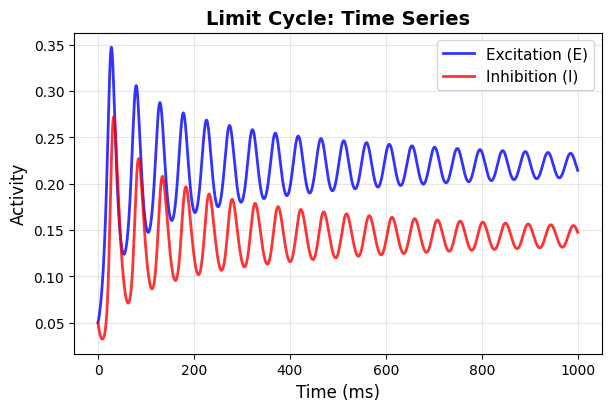

In [4]:
stable_fixed_point = dict(base, wEE=10.0, wEI=12.0, wIE=10.0, wII=2.0, P=1.0, rI0=0.05, rE0=0.05, duration=1e3 * u.ms)
simulate(**stable_fixed_point)

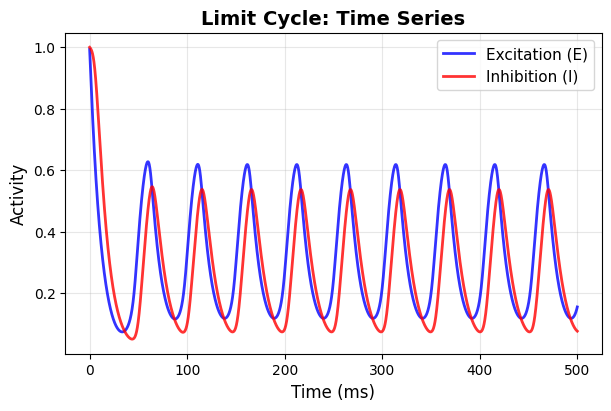

In [5]:
damped_oscillations = dict(base, wEE=12.0, wEI=10.0, wIE=12.0, wII=2.0, P=1.2)
simulate(**damped_oscillations)

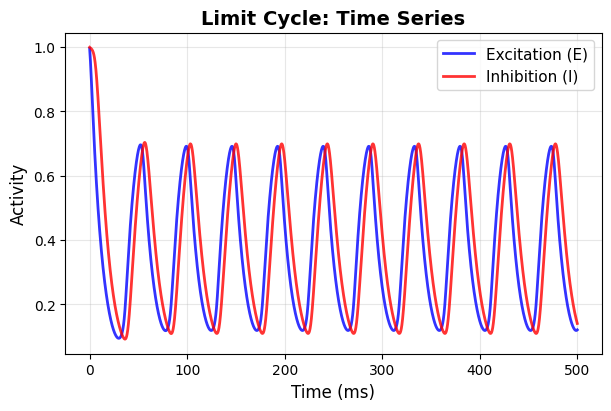

In [6]:
limit_cycle = dict(base, wEE=16.0, wEI=12.0, wIE=15.0, wII=3.0, P=1.7)
simulate(**limit_cycle)

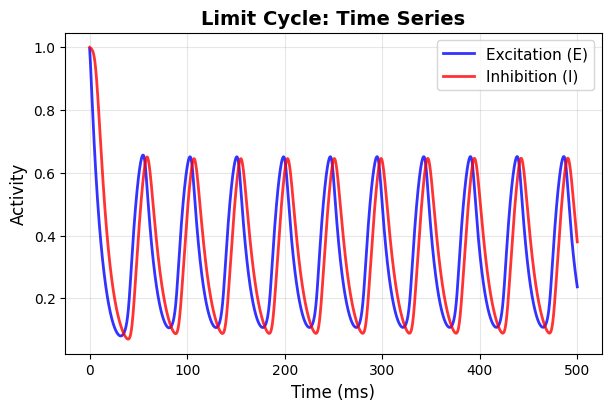

In [7]:
# Quasi-entrained oscillations via periodic drive
def P_drive(t):
    # baseline + sinusoidal drive
    return 1.4 + 0.35 * u.math.sin(2 * u.math.pi * 0.015 * u.Hz * t)  # slow modulation


periodic_drive = dict(base, wEE=15.0, wEI=12.0, wIE=14.0, wII=3.0, P=P_drive)
simulate(**periodic_drive)

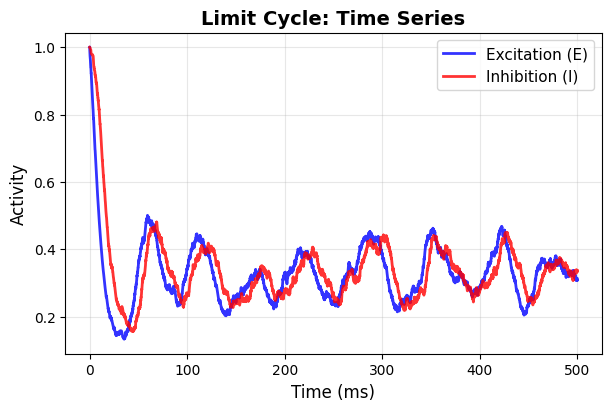

In [8]:
dt = u.get_magnitude(brainstate.environ.get_dt())
noisy_near_threshold = dict(
    base,
    wEE=14.0, wEI=12.0, wIE=13.0, wII=3.0,
    P=1.35,
    noise_E=brainmass.GaussianNoise(1, sigma=2),
    noise_I=brainmass.GaussianNoise(1, sigma=2),
)
simulate(**noisy_near_threshold)